In [1]:
import cv2
import numpy as np
import os
from keras.utils import np_utils
from matplotlib import pyplot as plt
import time
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras import applications
from keras.optimizers import SGD
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score
from keras.models import load_model
import itertools

Using TensorFlow backend.


In [2]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,precision_recall_fscore_support

# Loading the Dataset

In [13]:
train_data_dir = 'cell_images'
labels = os.listdir(train_data_dir)
total = len(labels)

nb_train_samples = 27560 #  training samples
num_classes = 2
img_rows_orig = 100
img_cols_orig = 100

X_train = np.ndarray((nb_train_samples, img_rows_orig, img_cols_orig, 3), dtype=np.uint8)
Y_train = np.zeros((nb_train_samples,), dtype='uint8')

In [16]:
i = 0
print('-'*30)
print('Creating training images...')
print('-'*30)
j = 0
for label in labels:
    image_names_train = os.listdir(os.path.join(train_data_dir, label))
    total = len(image_names_train)
    print(label, total)
    for image_name in image_names_train:
        img = cv2.imread(os.path.join(train_data_dir, label, image_name), cv2.IMREAD_COLOR)
        if(img is not None):
            img = cv2.resize(img, (img_rows_orig,img_cols_orig))
            img = np.array([img])
            X_train[i] = img
            Y_train[i] = j

            if i % 100 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
    j += 1    
print(i)                
print('Loading done.')

print('Transform targets to keras compatible format.')
Y_train = np_utils.to_categorical(Y_train[:nb_train_samples], num_classes)
np.savez('imgs_train1.npz', X_train = X_train, Y_train = Y_train)

------------------------------
Creating training images...
------------------------------
Parasitized 13780
Done: 0/13780 images
Done: 100/13780 images
Done: 200/13780 images
Done: 300/13780 images
Done: 400/13780 images
Done: 500/13780 images
Done: 600/13780 images
Done: 700/13780 images
Done: 800/13780 images
Done: 900/13780 images
Done: 1000/13780 images
Done: 1100/13780 images
Done: 1200/13780 images
Done: 1300/13780 images
Done: 1400/13780 images
Done: 1500/13780 images
Done: 1600/13780 images
Done: 1700/13780 images
Done: 1800/13780 images
Done: 1900/13780 images
Done: 2000/13780 images
Done: 2100/13780 images
Done: 2200/13780 images
Done: 2300/13780 images
Done: 2400/13780 images
Done: 2500/13780 images
Done: 2600/13780 images
Done: 2700/13780 images
Done: 2800/13780 images
Done: 2900/13780 images
Done: 3000/13780 images
Done: 3100/13780 images
Done: 3200/13780 images
Done: 3300/13780 images
Done: 3400/13780 images
Done: 3500/13780 images
Done: 3600/13780 images
Done: 3700/13780

data = np.load('imgs_train1.npz')
X = data['X_train']
Y = data['Y_train']

indices = np.arange(27558)
np.random.shuffle(indices)
train_indices =  indices[0:22500]
valid_indices = indices[22500:]

X_train = X[train_indices]
Y_train = Y[train_indices]
X_valid = X[valid_indices]
Y_valid = Y[valid_indices]

In [ ]:
np.savez('imgs_train_valid.npz', X_train = X_train, Y_train = Y_train,X_valid = X_valid,Y_valid  = Y_valid)

In [3]:
data = np.load('imgs_train_valid.npz')
X_train = data['X_train']
Y_train = data['Y_train']
X_valid = data['X_valid']
Y_valid = data['Y_valid']

<function matplotlib.pyplot.show(*args, **kw)>

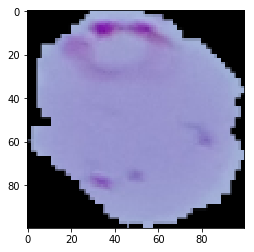

In [17]:
plt.imshow(X_valid[40])
plt.show

In [10]:
print(Y_valid[40])

[1. 0.]


# Model Definition

In [6]:
img_rows=100 #dimensions of image
img_cols=100
channel = 3 #RGB
batch_size = 64 #vary depending on the GPU
num_epoch = 100
num_classes = 2

In [7]:
#VGG16 model
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(100,100,3))
base_model = Model(input=base_model.input, output=base_model.get_layer('block5_conv2').output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
#Inception model
base_model = applications.Xception(weights='imagenet', include_top=False, input_shape=(100,100,3))
base_model = Model(input=base_model.input, output=base_model.get_layer('block14_sepconv1').output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
#Resnet model
#base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
#base_model = Model(input=base_model.input, output=base_model.get_layer('res5c_branch2c').output)

In [8]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [5]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

In [6]:
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer 
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [8]:
for layer in base_model.layers:
    layer.trainable = False
# compile the model (should be done *after* setting layers to non-trainable)
#fix the optimizer
sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True) 
#compile the gpu model
model.compile(optimizer=sgd,
              loss='mse',
              metrics=['accuracy'])

In [ ]:
t=time.time() #make a note of the time
#start training
print('-'*30)
print('Start Training the model...')
print('-'*30)
hist = model.fit(X_train, Y_train,
      batch_size=batch_size,
      epochs=num_epoch,
      shuffle=True,
      validation_data=None,
      verbose=1)

#compute the training time
print('Training time: %s' % (time.time()-t))

------------------------------
Start Training the model...
------------------------------
Epoch 1/100
22500/22500 [==============================] - 101s 4ms/step - loss: 0.4660 - acc: 0.5241
Epoch 2/100
22500/22500 [==============================] - 50s 2ms/step - loss: 0.4273 - acc: 0.5620
Epoch 3/100
22500/22500 [==============================] - 50s 2ms/step - loss: 0.3960 - acc: 0.5933
Epoch 4/100
22500/22500 [==============================] - 50s 2ms/step - loss: 0.3661 - acc: 0.6235
Epoch 5/100
22500/22500 [==============================] - 50s 2ms/step - loss: 0.3433 - acc: 0.6476
Epoch 6/100
22500/22500 [==============================] - 50s 2ms/step - loss: 0.3234 - acc: 0.6680
Epoch 7/100
22500/22500 [==============================] - 50s 2ms/step - loss: 0.3031 - acc: 0.6886
Epoch 8/100
22500/22500 [==============================] - 50s 2ms/step - loss: 0.2891 - acc: 0.7025
Epoch 9/100
22500/22500 [==============================] - 49s 2ms/step - loss: 0.2749 - acc: 0.7169


model.save('model_inception.h5')

model.save('model.h5')

In [11]:
model = load_model('model.h5')
#model = load_model('model_inception.h5')

In [12]:
y_pred = model.predict(X_valid, batch_size=64, verbose=1)

5058/5058 [==============================] - 53s 10ms/step


Predicted :
    Infected
Ground Truth :
    Infected


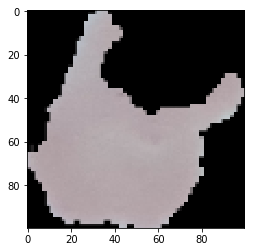

In [18]:
plt.imshow(X_valid[400])
plt.show
print('Predicted :')
print('    Uninfected') if np.argmax(y_pred[500]) else print('    Infected')
print('Ground Truth :')
print('    Uninfected') if np.argmax(Y_valid[500]) else print('    Infected')

Predicted :
    Infected
Ground Truth :
    Infected


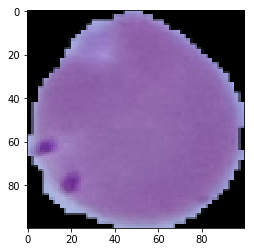

In [19]:
plt.imshow(X_valid[1000])
plt.show
print('Predicted :')
print('    Uninfected') if np.argmax(y_pred[1000]) else print('    Infected')
print('Ground Truth :')
print('    Uninfected') if np.argmax(Y_valid[1000]) else print('    Infected')

Predicted :
    Uninfected
Ground Truth :
    Uninfected


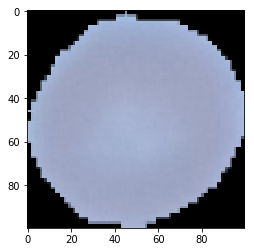

In [20]:
plt.imshow(X_valid[66])
plt.show
print('Predicted :')
print('    Uninfected') if np.argmax(y_pred[66]) else print('    Infected')
print('Ground Truth :')
print('    Uninfected') if np.argmax(Y_valid[66]) else print('    Infected')

In [20]:
Validation_accuracy = accuracy_score(Y_valid.argmax(axis=-1),y_pred.argmax(axis=-1))
print("Validation_Accuracy = ",Validation_accuracy*100,"%")

Validation_Accuracy =  94.32582048240411 %


Confusion matrix, without normalization
[[2336  171]
 [ 116 2435]]


Text(0.5,-20.6968,'Predicted label')

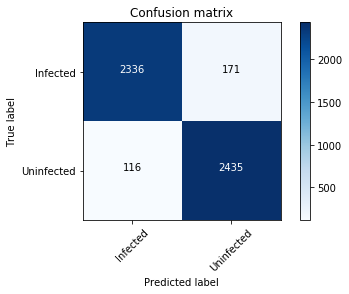

In [42]:
classes = ['Infected','Uninfected']
cm = confusion_matrix(Y_valid.argmax(axis=-1),y_pred.argmax(axis=-1))
normalize = False
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')

print(cm)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [20]:
y_pred = np.argmax(y_pred, axis=1)
Y_valid = np.argmax(Y_valid, axis=1)
print(y_pred)
print(Y_valid)

#save the predicted and ground-truth labels.
np.savetxt('malaria_y_pred.csv',y_pred,fmt='%i',delimiter = ",")
np.savetxt('malaria_Y_true.csv',Y_valid,fmt='%i',delimiter = ",")

[0 0 1 ... 0 1 1]
[0 0 1 ... 0 1 1]
